In [16]:
%reset-f
%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from pandas.io import wb
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from res_ind_lib import *
import os, time
import warnings
import fileinput
from subprocess import call

from IPython.display import SVG,Image


warnings.filterwarnings("always",category=UserWarning)

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def n_to_one_normalizer(s,n=0):
    y =(s-s.min())/(s.max()-s.min())
    return n+(1-n)*y
    
def bins_normalizer(x,n=7):
    n=n-1
    y= zero_to_one_normalizer(x)  #0 to 1 numbe
    return np.floor(n*y)/n

def quantile_normalizer(column, nb_quantile=5):
    return (pd.qcut(column, nb_quantile,labels=False))/(nb_quantile-1)

def num_to_hex(x):
    h = hex(int(255*x)).split('x')[1]
    if len(h)==1:
        h="0"+h
    return h

def data_to_rgb(serie,color_maper=plt.cm.get_cmap("Blues_r"),normalizer=n_to_one_normalizer,norm_param=0):    
    data_n = normalizer(serie,norm_param).dropna()
    colors = pd.DataFrame(color_maper(data_n),index=df.index, columns=["r","g","b","a"]).applymap(num_to_hex)
    return "#"+colors.r+colors.g+colors.b

In [19]:
def append_styles_to_map(outmap,styles,inmap='BlankWorldMap.svg'):
    inFile = open(inmap)
    outFile = open(outmap+".svg", "w")
    buffer = ['']
    isreplacing=False
    for line in inFile:
        if line.startswith('/* Begin country color*/'):
            isreplacing=True
            buffer.append(line)
            buffer.append(styles)
        elif line.startswith('/* End country color*/'):
            isreplacing=False
        if not isreplacing:
            buffer.append(line)
    outFile.write("".join(buffer))
    inFile.close()
    outFile.close()
    
    call("inkscape -f {map}.svg -e {map}.png -d 150".format(map=outmap))


###Data

In [20]:
#Get resilience, country name, and iso2
df = pd.read_csv('df.csv').dropna().set_index("iso3")
iso3_to_iso2 = pd.read_csv("names_to_iso.csv")[["iso2","iso3"]].drop_duplicates().set_index("iso3")

df["iso2"]=iso3_to_iso2["iso2"]

cond = df["iso2"].isnull()
if cond.sum()>0:
    warnings.warn("no iso2 codefound for ", ",".join(data.index[cond].values))

#data=data.reset_index().set_index("iso2").drop("iso3",axis=1)

df["logrisk"] = np.log10(df.risk)

df["resi_color"]=data_to_rgb(df.resilience)
df["risk_color"]=data_to_rgb(df.risk,plt.cm.get_cmap("Reds"))
df["log_risk_color"]=data_to_rgb(df.logrisk,plt.cm.get_cmap("Reds"))

###Map

In [21]:
style_base =\
""".landxx.{iso2}
{{  
   fill: {color};
   stroke:#000000;
   stroke-width:0.3;
   fill-rule:evenodd;
}}"""

In [22]:
styles_rl=styles_r=styles=""
for c in df.index:
    styles = styles     + style_base.format(iso2=df["iso2"][c].lower(),color=df["resi_color"][c])+ "\n"
    styles_r = styles_r + style_base.format(iso2=df["iso2"][c].lower(),color=df["risk_color"][c])+ "\n"
    styles_rl = styles_rl + style_base.format(iso2=df["iso2"][c].lower(),color=df["log_risk_color"][c])+ "\n"
    
append_styles_to_map("map_of_resilience",styles)
append_styles_to_map("map_of_risk",styles_r)
append_styles_to_map("map_of_log_risk",styles_rl)

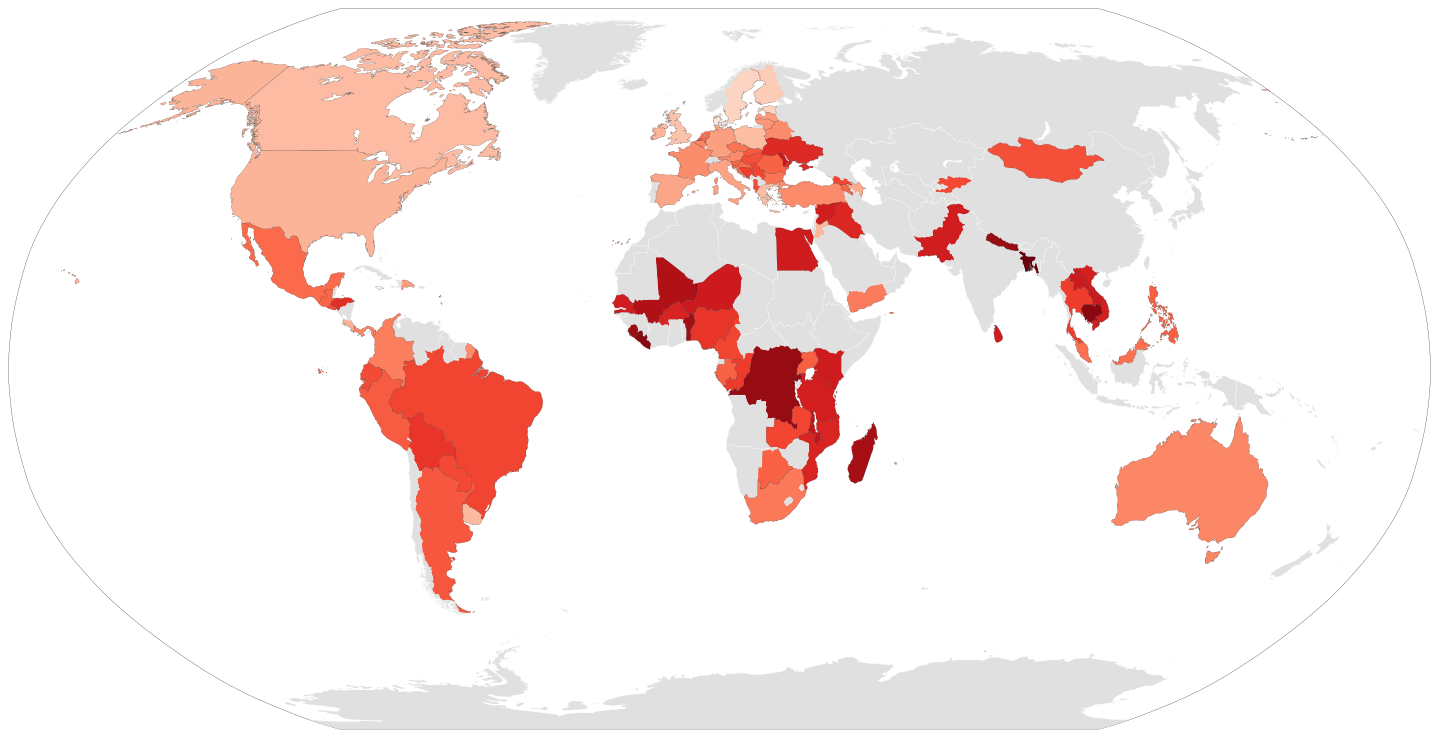

In [23]:
Image("map_of_log_risk.png",width=700)

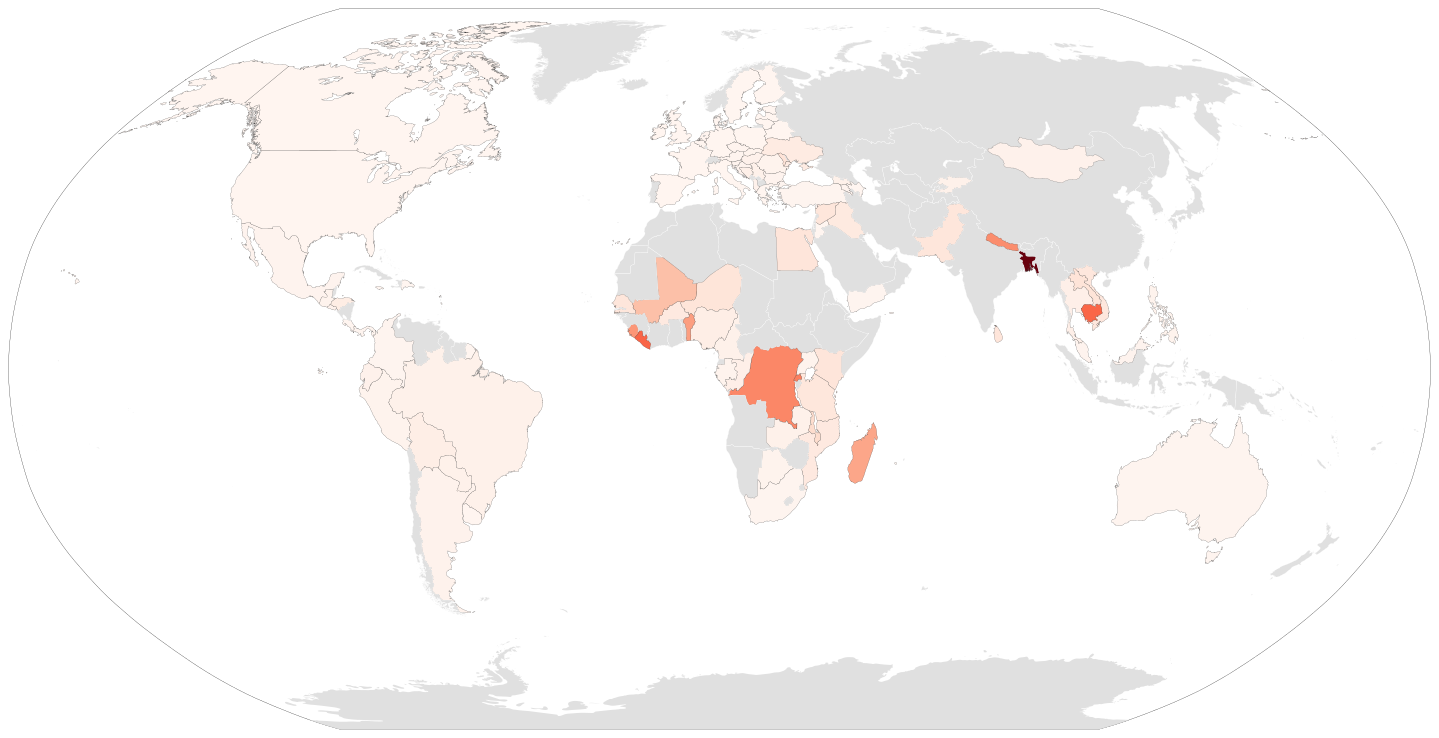

In [24]:
Image("map_of_risk.png",width=700)

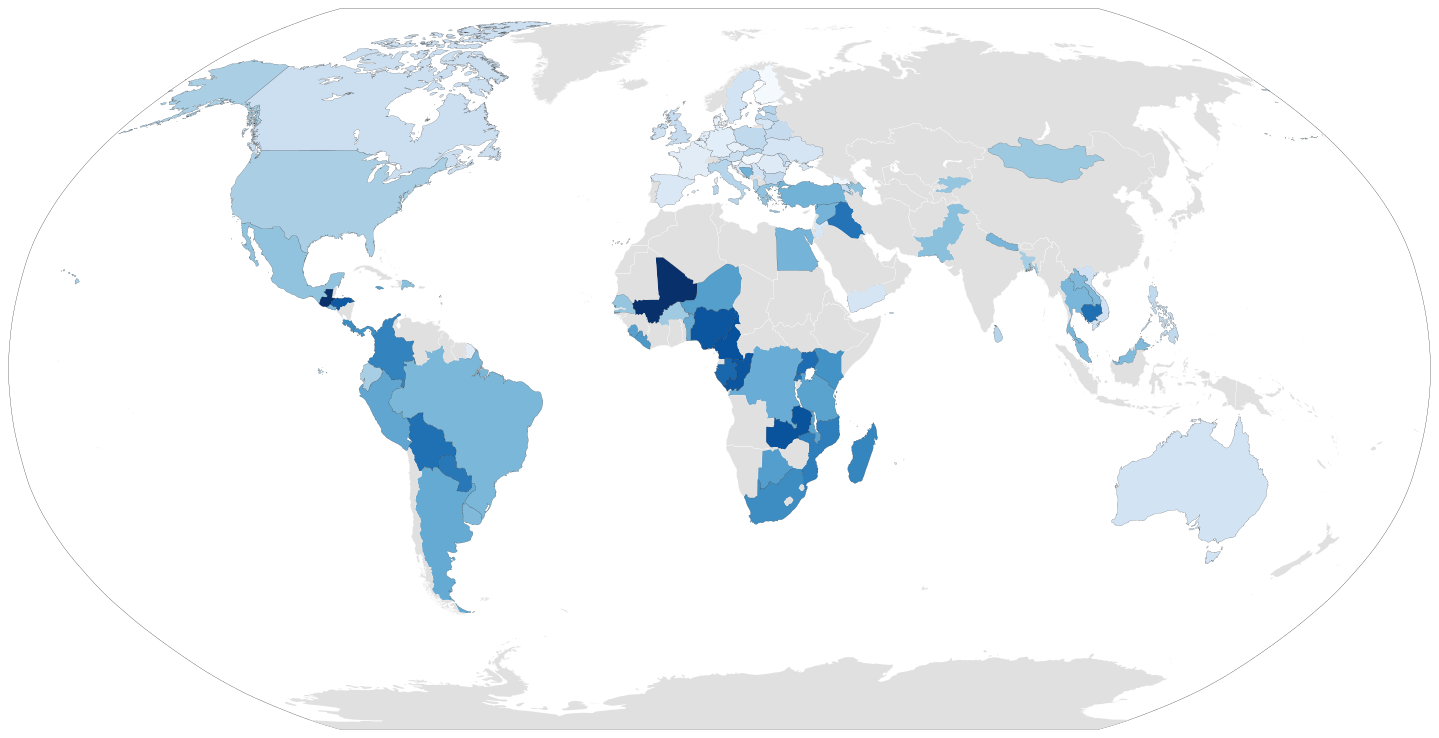

In [25]:
Image("map_of_resilience.png",width=700)

#Legend

In [26]:
smallfont = {'family' : 'sans serif', 'size'   : 18}

font = {'family' : 'sans serif',
    'size'   : 22}

boldfont = {'family' : 'sans serif',
     'weight': 'bold',           
     'size'   : 22}

bigfont = {'family' : 'serif',
     'size'   : 26}


plt.rc('font', **font)
plt.rcParams["savefig.dpi"]=90

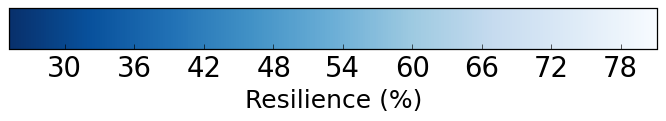

In [27]:
import matplotlib as mpl


fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cmap = mpl.cm.get_cmap("Blues_r")
norm = mpl.colors.Normalize(vmin=df.resilience.min()*100, vmax=df.resilience.max()*100)


cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm,
                                   orientation='horizontal')
cb.set_label('Resilience (%)',size=20)
plt.savefig("legend_resilience.png")

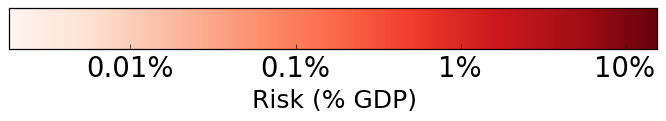

In [28]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cmap = mpl.cm.get_cmap("Reds")
norm = mpl.colors.Normalize(vmin=(df.logrisk.min()), vmax=(df.logrisk.max()))


cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm,
                                   orientation='horizontal',ticks=range(-4,0))
cb.ax.set_xticklabels(['0.01%','0.1%','1%','10%'])
cb.set_label('Risk (% GDP)',size=20)

plt.savefig("legend_log_risk.png")

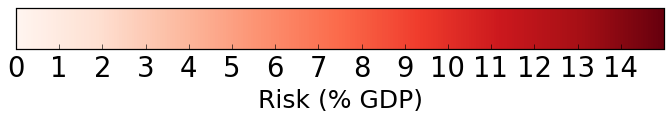

In [29]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cmap = mpl.cm.get_cmap("Reds")
norm = mpl.colors.Normalize(vmin=int(df.risk.min()*100), vmax=int(df.risk.max()*100))


cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm,
                                   orientation='horizontal',ticks=range(0,15))
cb.set_label('Risk (% GDP)',size=20)

plt.savefig("legend_risk.png")

### Example: how to build own  color map

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#Example: building one's own colormap (not used)
cMap = []
#for value, colour in zip([0,1,2,3,4],["#d7191c", "#fdae61", "#ffffbf", "#abd9e9", "#2c7bb6"]):
for value, colour in zip([0,1,2,3,4,5,6],["#d73027", "#fc8d59", "#fee090", "#ffffbf", "#e0f3f8", "#91bfdb", "#4575b4"]):
    cMap.append((value/6, colour))
colorMap = LinearSegmentedColormap.from_list("custom", cMap)

 
